In [1]:
using Pkg
Pkg.activate("..")
using Revise
using FUSE
using FUSE.IMAS
using Plots; gr();

  Activating environment at `~/Coding/julia/FUSE/Project.toml`
┌ Info: Precompiling FUSE [e64856f0-3bb8-4376-b4b7-c03396503992]
└ @ Base loading.jl:1317
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/3fzVq/src/RecipesBase.jl:117
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/3fzVq/src/RecipesBase.jl:117
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/3fzVq/src/RecipesBase.jl:117
  ** incremental compilation may be fatally broken for this module **



In [2]:
filename=joinpath(dirname(abspath(@__FILE__)),"..","sample","CAT_eq_ods.json")
dd = IMAS.json2imas(filename);
IMAS.flux_surfaces(dd.equilibrium);

equilibrium.ids_properties was skipped in IMAS.jl data dictionary


In [ ]:
ϵ = 0.48
κ = 1.68
δ = 0.21
R0 = 6.2
B0 = 5.3
ip = 15.E6
beta_n = 1.0
x_point=(5.0,-6.0)
symmetric=true

resolution = 129

dd = IMAS.dd()
resize!(dd.equilibrium.time_slice,1)
FUSE.init(dd.equilibrium.time_slice[1]; B0, R0, ϵ, δ, κ, beta_n, ip, x_point=x_point)

eqactor = FUSE.SolovevEquilibriumActor(dd.equilibrium.time_slice[1], symmetric=symmetric)
@time FUSE.step(eqactor)
dd.equilibrium.time_slice[1] = FUSE.finalize(eqactor, resolution, (maximum([R0*(1-ϵ*2),0.0]), R0*(1+ϵ*2)), (-R0*ϵ*κ*2, R0*ϵ*κ*2))
dd.equilibrium.time=[0.0]
dd.equilibrium.vacuum_toroidal_field.r0=R0
dd.equilibrium.vacuum_toroidal_field.b0=[B0]

plot(dd.equilibrium.time_slice[1])

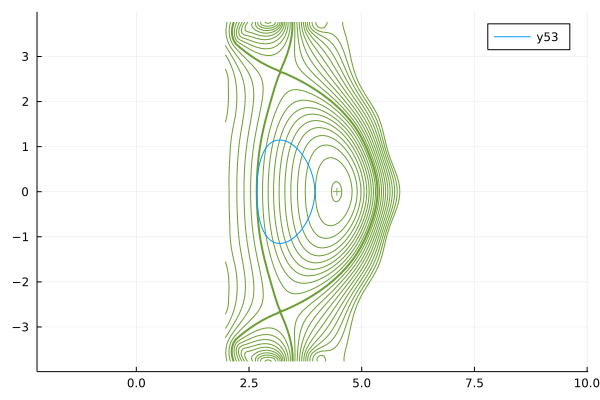

In [3]:
resize!(dd.equilibrium.time_slice,2);
eq=dd.equilibrium
eq.time_slice[2].global_quantities.psi_boundary=-0.12
α=0.25
eq.time_slice[2].boundary.outline.r,eq.time_slice[2].boundary.outline.z,_=IMAS.flux_surface(eq.time_slice[1],eq.time_slice[1].profiles_1d.psi[1]*(1-α)+eq.time_slice[1].profiles_1d.psi[end]*α)
eq.time_slice[2].boundary.outline.r.-=minimum(eq.time_slice[2].boundary.outline.r).-minimum(IMAS.flux_surface(eq.time_slice[1],eq.time_slice[1].profiles_1d.psi[end])[1])
eq.time_slice[2].time = -1.0
push!(eq.time,-1.0)

plot(dd.equilibrium.time_slice[1])
plot!(eq.time_slice[2].boundary.outline.r,eq.time_slice[2].boundary.outline.z)

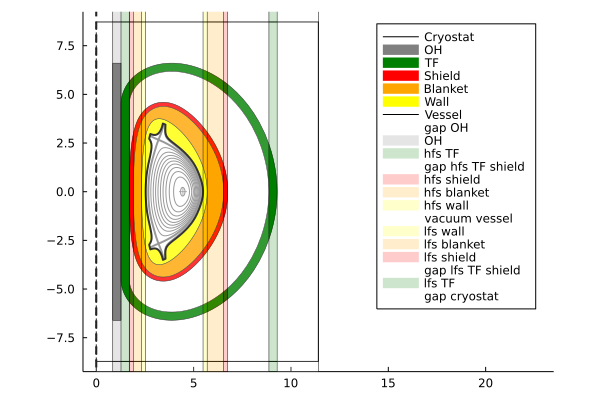

In [7]:
# initialize radial build IDS
eqt=dd.equilibrium.time_slice[1]
rb=dd.radial_build=IMAS.radial_build()
FUSE.init(rb, eqt, is_nuclear_facility=true, conformal_wall=true);

# run RampupActor
ohactor = FUSE.RampupActor(rb, eqt, ejima=0.4)
FUSE.step(ohactor)
FUSE.finalize(ohactor)

plot(eqt,color=:gray)
plot!(rb,outline=true)
display(plot!(rb,cx=false))

In [195]:
# initialize pf actor
pfoptactor = PFcoilsOptActor(dd.equilibrium, dd.radial_build, 5, [0, 5], 1E-7)
FUSE.step(pfoptactor, λ_ψ=1E-2, λ_null=1E-2, λ_currents=1E5, verbose=true, symmetric=true, maxiter=10000, optimization_scheme=:static);
FUSE.finalize(pfoptactor);

 * Status: success

 * Candidate solution
    Final objective value:     2.111865e-01

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit 120)
    Iterations:    10
    f(x) calls:    21



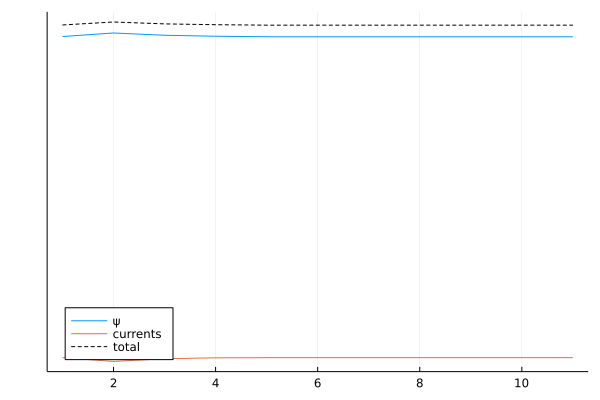

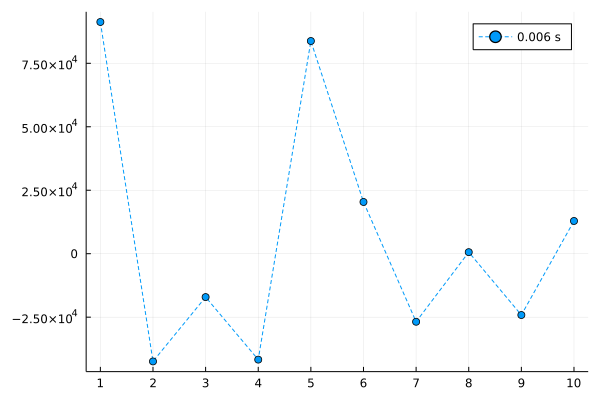

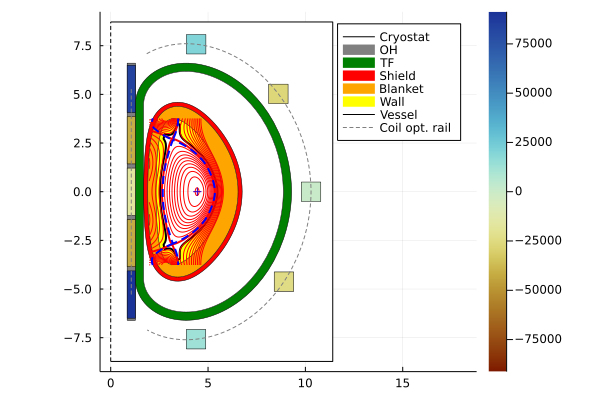

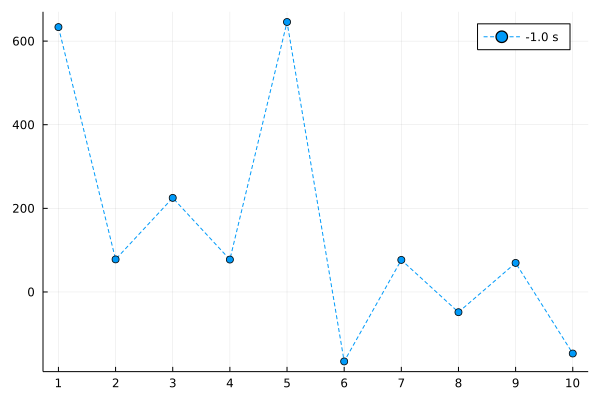

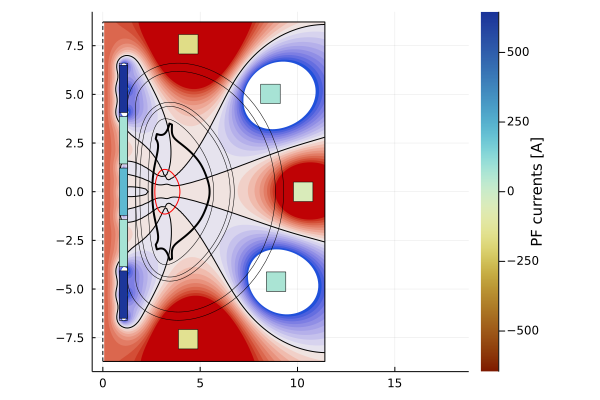

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/meneghini/.julia/packages/PlotUtils/VgXdq/src/ticks.jl:294
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/meneghini/.julia/packages/PlotUtils/VgXdq/src/ticks.jl:294


In [196]:
display(plot(pfoptactor.trace,:cost,start_at=1))

display(plot(pfoptactor.pf_active,:currents, time_index=1))
display(plot(pfoptactor,equilibrium=true,rail=true,time_index=1))

display(plot(pfoptactor.pf_active,:currents, time_index=2))
display(plot(pfoptactor,equilibrium=true,time_index=2))

In [197]:
# run pf actor
FUSE.step(pfoptactor, λ_ψ=1E-2, λ_null=1E-2, λ_currents=1E5, verbose=true, symmetric=true, maxiter=10000, optimization_scheme=:rail);
FUSE.finalize(pfoptactor);

 * Status: success

 * Candidate solution
    Final objective value:     2.538149e-01

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   25  (vs limit 120)
    Iterations:    214
    f(x) calls:    446



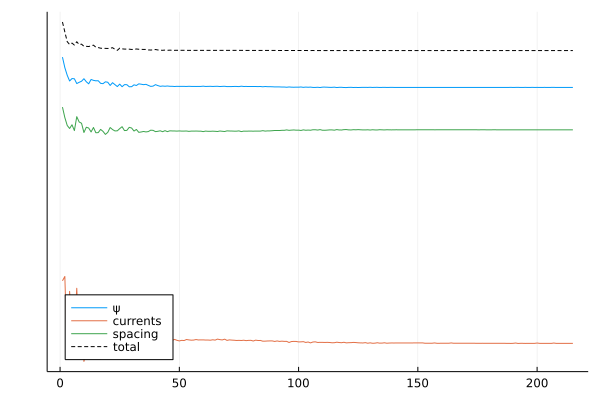

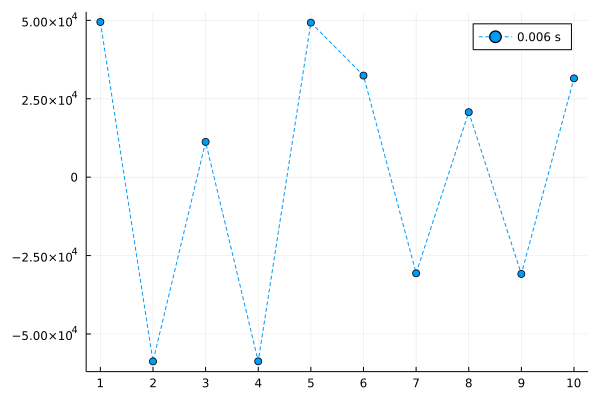

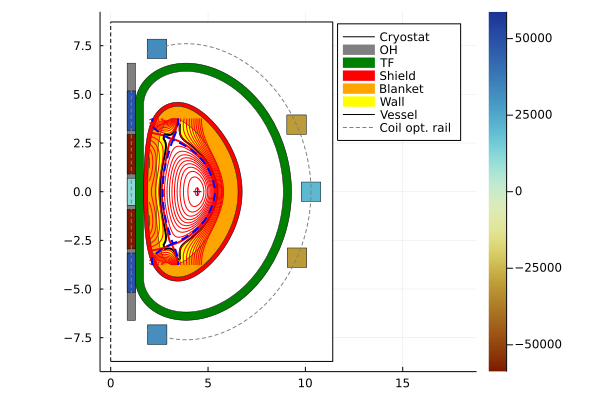

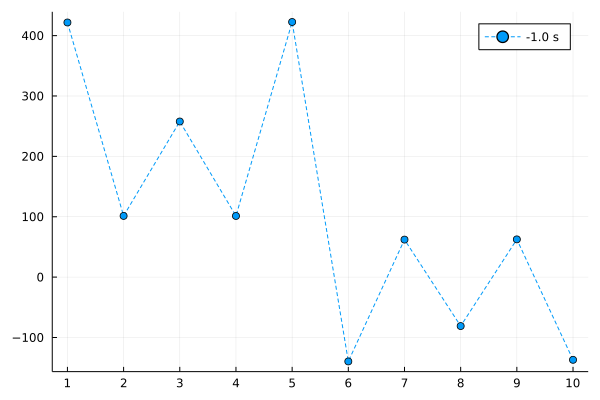

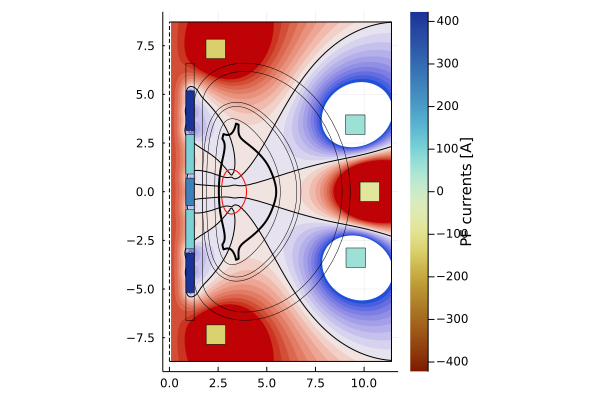

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/meneghini/.julia/packages/PlotUtils/VgXdq/src/ticks.jl:294
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/meneghini/.julia/packages/PlotUtils/VgXdq/src/ticks.jl:294


In [199]:
display(plot(pfoptactor.trace,:cost,start_at=1))

display(plot(pfoptactor.pf_active,:currents, time_index=1))
display(plot(pfoptactor,equilibrium=true,rail=true,time_index=1))

display(plot(pfoptactor.pf_active,:currents, time_index=2))
display(plot(pfoptactor,equilibrium=true,time_index=2,plot_r_buffer=1.0))

#IMAS.imas2json(rb,"radial_build_4.json")

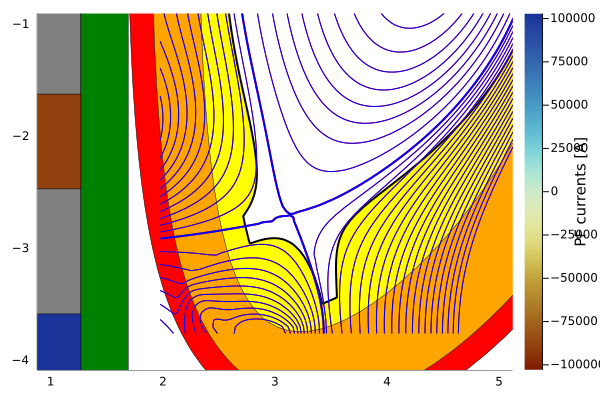

In [27]:
psi_levels_out=21
FUSE.step(pfoptactor, maxiter=-1);
plot(rb)
plot!(pfoptactor.eq_out.time_slice[1],xlim=[1,5],ylim=[-4,-1],legend=:none,color=:red,psi_levels_out=psi_levels_out)
#plot!(pfoptactor)
for coil in pfoptactor.pf_active.coil
    if coil.identifier=="fixed"
        coil.current.data=-coil.current.data
    end
end
FUSE.step(pfoptactor, maxiter=-1);
plot!(pfoptactor.eq_out.time_slice[1],xlim=[1,5],ylim=[-4,-1],legend=:none,color=:blue,psi_levels_out=psi_levels_out)
display(plot!(pfoptactor.pf_active))

In [124]:
# currents=[coil.current.data[1] for coil in pfoptactor.pf_active.coil]
# p = plot(currents)

# index=[]
# for (k,coil) in reverse(collect(enumerate(pfoptactor.pf_active.coil)))
#     if abs(coil.current.data[1])<1000*200
#         currents[k]=NaN
#         deleteat!(pfoptactor.pf_active.coil,k)
#     else
#         push!(index,k)
#     end
# end
# FUSE.step(pfoptactor, maxiter=0, λ_regularize=1E-8)

# for (k,coil) in reverse(collect(enumerate(pfoptactor.pf_active.coil)))
#     currents[reverse(index)[k]]=coil.current.data[1]
# end

# display(plot!(p, currents))

# plot(rb)
# plot!(pfoptactor)

In [122]:
println(pfoptactor.pf_active)

coil
｜[1]
｜｜current
｜｜｜data ➡ 2-element Vector{Float64}
｜｜｜time ➡ 2-element Vector{Float64}
｜｜element
｜｜｜[1]
｜｜｜｜geometry
｜｜｜｜｜rectangle
｜｜｜｜｜｜height ➡ 1.7765078641952798
｜｜｜｜｜｜r ➡ 1.0573601015180314
｜｜｜｜｜｜width ➡ 0.4229440406072126
｜｜｜｜｜｜z ➡ -4.564540466985122
｜｜｜｜turns_with_sign ➡ 302
｜｜identifier ➡ "optim"
｜｜name ➡ "oh"
｜[2]
｜｜current
｜｜｜data ➡ 2-element Vector{Float64}
｜｜｜time ➡ 2-element Vector{Float64}
｜｜element
｜｜｜[1]
｜｜｜｜geometry
｜｜｜｜｜rectangle
｜｜｜｜｜｜height ➡ 1.7765078641952794
｜｜｜｜｜｜r ➡ 1.0573601015180314
｜｜｜｜｜｜width ➡ 0.4229440406072126
｜｜｜｜｜｜z ➡ -2.688032602789842
｜｜｜｜turns_with_sign ➡ 302
｜｜identifier ➡ "optim"
｜｜name ➡ "oh"
｜[3]
｜｜current
｜｜｜data ➡ 2-element Vector{Float64}
｜｜｜time ➡ 2-element Vector{Float64}
｜｜element
｜｜｜[1]
｜｜｜｜geometry
｜｜｜｜｜rectangle
｜｜｜｜｜｜height ➡ 1.6497786706922026
｜｜｜｜｜｜r ➡ 1.0573601015180314
｜｜｜｜｜｜width ➡ 0.4229440406072126
｜｜｜｜｜｜z ➡ -0.8748893353461005
｜｜｜｜turns_with_sign ➡ 280
｜｜identifier ➡ "optim"
｜｜name ➡ "oh"
｜[4]
｜｜current
｜｜｜data ➡ 2-element